<a href="https://colab.research.google.com/github/flora0110/spotify_segment_headine/blob/main/podcast_to_headline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [1]:
!pip install word2vec

     |████████████████████████████████| 42 kB 510 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=c95834875818905afa6cdde05547f62422440b8fb328f2a34598bb6d713f2ee9
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [2]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [36]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

In [37]:
links = {'history': 'https://raw.githubusercontent.com/flora0110/spotify_segment_headine/main/podcast_data/history_comma.txt',  # a tale of two cities
         'sugar': 'https://raw.githubusercontent.com/flora0110/spotify_segment_headine/main/podcast_data/SugarCravings.txt'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

## Train wordvectors

In [4]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [5]:
model.save(wrdvec_path)

In [6]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [7]:
!pip install textsplit

     |████████████████████████████████| 154 kB 5.2 MB/s 


In [8]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [27]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### history podcast

In [32]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  30#@param {type:"integer"}

penalty 44.64
489 sentences, 20 segments, avg 24.45 sentences per segment
optimal score 9999.59, greedy score 9968.71
[9999.594204249992, 9968.705992640342]
(9999.594204249992, 9968.705992640342)
ratio of scores 1.0031


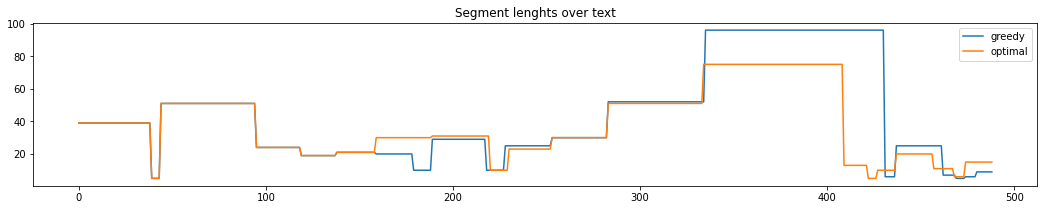

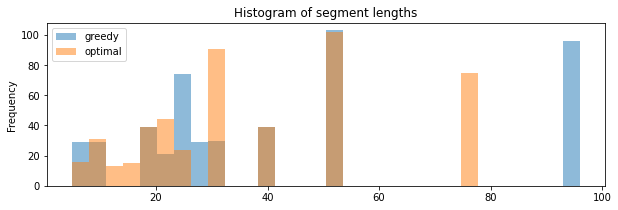

In [33]:
link = links['history']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [39]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey serían and this is the dark History Podcast. ', 'Whew, I need a theme song for dark history. ', "Don't, I'm anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that. ", 'I never learned in school. ', "If you're new here. ", 'Hi, welcome. ', 'Come. ', 'Take a seat by me. ', "Don't be shy if you're And learning about people and events that your history books didn't cover in school. ", "The maybe should have then you'll fit in right in here with us. ", 'Okay. ', "Look today's story. ", "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's just, it's set. ", "It's awful. ", "It's sad. ", "There's, those are all the words. ", "I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like no sugarcoating thi

# Headline generator

In [38]:
! pip install transformers datasets

     |████████████████████████████████| 3.8 MB 5.0 MB/s 
     |████████████████████████████████| 325 kB 61.8 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 6.5 MB 42.7 MB/s 
     |████████████████████████████████| 895 kB 68.0 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 136 kB 42.3 MB/s 
     |████████████████████████████████| 1.1 MB 53.7 MB/s 
     |████████████████████████████████| 212 kB 56.4 MB/s 
     |████████████████████████████████| 127 kB 41.5 MB/s 
     |████████████████████████████████| 94 kB 3.2 MB/s 
     |████████████████████████████████| 271 kB 56.1 MB/s 
     |████████████████████████████████| 144 kB 53.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling

In [40]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.1 MB/s 


### 處理輸入

In [45]:
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [46]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [47]:
summarizer = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [48]:
summary = summarizer(podcast_test, min_length=5, max_length=90)

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [52]:
for sum in summary:
  print(sum['generated_text'])

The Dark History Podcast
The Death of James Taylor
The Rosewood Massacre
Best Fiends - The Mobile Puzzle Game That Will Put A Challenge To Your Noggin
Best Fiends - The Best Fiends Game
What's Going On Screaming?
The Story of Fanny and the Black Man Attacked Her
Sarah's Version of the White Man Attacking Fanny
Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, Jesse Hunter, J
The Posse, The Posse
Sam Carter, The Posse, The Posse
Hello Fresh - America's Number One Meal Kit
The Black Community in Rosewood, Texas
John, Save His House, But Burn All These Over Here
Rosewood Massacre - Five of the Rosewood Massacre
The Klu Klux Klan is a gang of a bunch of people.
The Mob Kills Black Residents in Rosewood
Rosewood, OH, Those Who Are Trying to Escape Des